<a href="https://colab.research.google.com/github/kooose38/anomaly-detection-gan/blob/master/anogan_2196404_ed4d_4996_a858_3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 画像への異常検知タスク
モデル: SAGAN+AnoGAN  
データセット: 犬と猫  
概要: 正常画像を犬画像として、猫画像が入力された際に異常検知をする  
評価: GPUが足らないため学習できず。

### load dataset

In [1]:
%cd ./drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [2]:
!pip install -q icrawler

In [ ]:
from icrawler.builtin import BingImageCrawler

c = BingImageCrawler(storage={"root_dir": "cat"})
c.crawl(keyword="猫", max_num=100)

d = BingImageCrawler(storage={"root_dir": "dog"})
d.crawl(keyword="犬", max_num=100)

In [6]:
import os 
from glob import glob 
from PIL import Image 
dog_list = []
cat_list = []

for dog_path in glob("./dog"+"/"+"*.jpg"):
    d_img = Image.open(dog_path)
    dog_list.append(d_img)

for cat_path in glob("./cat"+"/"+"*.jpg"):
    c_img = Image.open(cat_path)
    cat_list.append(c_img)
    

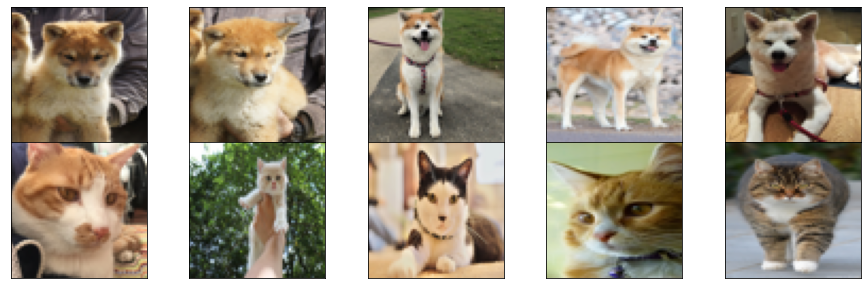

In [11]:
import matplotlib.pyplot as plt
import numpy as np 

fig, axes = plt.subplots(2, 5, figsize=(16, 5))
ax = axes.ravel()
for i in range(5):
    ax[i].imshow(np.array(dog_list[i].resize((64, 64))))
    ax[i+5].imshow(np.array(cat_list[i].resize((64, 64))))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i+5].set_xticks([])
    ax[i+5].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### preprocessing 

In [39]:
import torch, torchvision 
from torchvision import transforms 
from typing import  Union, Dict, List, Tuple 

class Transform():
    def __init__(self, resize: int, mean: Tuple[float], std: Tuple[float]):
        self.data_transform = {
            "train": transforms.Compose([
                                         transforms.Resize((resize, resize)), 
                                         transforms.ToTensor(), 
                                         transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, phase: str="train", img=None):
        return self.data_transform[phase](img)

resize = 64 
mean = (.5, )
std = (.5, )

transform = Transform(resize, mean, std)

In [38]:
train_ds, val_ds = [], []
for dog, cat in zip(dog_list, cat_list):
    dog_tensor = transform(img=dog)
    cat_tensor = transform(img=cat)

    data = {}
    data["inputs"] = dog_tensor 
    train_ds.append(data)

    a = np.random.rand(1)[0]
    data_ = {}
    if a >= 0.5:
        data_["inputs"] = cat_tensor 
    else:
        data_["inputs"] = cat_tensor 
    val_ds.append(data_)

In [42]:
from torch.utils.data import DataLoader 

train = DataLoader(train_ds, batch_size=32, shuffle=True)
val = DataLoader(val_ds, batch_size=32, shuffle=True)

for r in train:
    print(r["inputs"].size())
    print(r["inputs"][0])
    break 

torch.Size([32, 3, 64, 64])
tensor([[[ 0.5843,  0.5922,  0.5451,  ...,  0.3255,  0.2941,  0.1843],
         [ 0.6471,  0.6157,  0.5373,  ...,  0.2941,  0.2863,  0.2078],
         [ 0.6627,  0.6392,  0.5294,  ...,  0.3961,  0.3333,  0.2157],
         ...,
         [ 0.1843,  0.0118, -0.0039,  ...,  0.2706,  0.2706,  0.2000],
         [ 0.1373, -0.0431, -0.0431,  ...,  0.2863,  0.3333,  0.3255],
         [ 0.0118, -0.0353, -0.0510,  ...,  0.2078,  0.3804,  0.4275]],

        [[ 0.4039,  0.3961,  0.3725,  ...,  0.2235,  0.1765,  0.0588],
         [ 0.4510,  0.4275,  0.3725,  ...,  0.1686,  0.1608,  0.0745],
         [ 0.4667,  0.4667,  0.3647,  ...,  0.2471,  0.1922,  0.0745],
         ...,
         [ 0.3020,  0.1216,  0.0745,  ...,  0.2941,  0.2941,  0.2549],
         [ 0.2471,  0.0510,  0.0431,  ...,  0.3098,  0.4039,  0.4118],
         [ 0.0667,  0.0667,  0.0510,  ...,  0.1922,  0.4588,  0.5137]],

        [[ 0.1843,  0.1608,  0.1608,  ...,  0.0667,  0.0039, -0.1529],
         [ 0.1843

In [100]:
import pickle 
with open("dog_cat_val.pkl", "rb") as f:
    val = pickle.load(f)

### Model 

In [45]:
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.tensorboard import SummaryWriter 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
writer = SummaryWriter("tensorboard/")
print(device)

cpu


###### Generator 
(batch, 20) -> (batch, 3, 64, 64) 

In [46]:
class convTrans2normRelu(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, stride, padding=1, bias=False):
        super(convTrans2normRelu, self).__init__()
        self.conv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_c, out_c, kernel_size, stride, padding=padding, bias=bias))
        self.norm = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
    def forward(self, x, flg=False):
        if flg:
            return self.tanh(self.conv(x))
        else:
            return self.relu(self.norm(self.conv(x)))


In [56]:
class Generator(nn.Module):
    def __init__(self, z_dim: int=20, img_size: int=64, tag_c: int=3):
        super(Generator, self).__init__()
        self.layer1 = convTrans2normRelu(z_dim, img_size*8, 4, 1, 0)
        self.layer2 = convTrans2normRelu(img_size*8, img_size*4, 4, 2)
        self.layer3 = convTrans2normRelu(img_size*4, img_size*2, 4, 2)
        self.layer4 = convTrans2normRelu(img_size*2, img_size, 4, 2)
        self.layer5 = convTrans2normRelu(img_size, tag_c, 4, 2)

        self.attn1 = Self_Attention(img_size*2)
        self.attn2 = Self_Attention(img_size)

    def forward(self, z):
        z = z.view(-1, z.size()[1], 1, 1)
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.attn1(out)
        out = self.layer4(out)
        out = self.attn2(out)
        out = self.layer5(out, flg=True)
        return out 

###### Discriminator 
(batch, 3, 64, 64) -> (batch, 1)

In [64]:
class conv2leaky(nn.Module):
    def __init__(self, in_c, out_c, kernel_size, stride, padding=1, bias=False):
        super(conv2leaky, self).__init__()
        self.conv = nn.utils.spectral_norm(nn.Conv2d(in_c, out_c, kernel_size, stride, padding=padding, bias=bias))
        self.relu = nn.LeakyReLU(0.1, inplace=True)
    def forward(self, x):
        return self.relu(self.conv(x))

In [86]:
class Discriminator(nn.Module):
    def __init__(self, img_size: int=64, tag_c: int=1):
        super(Discriminator, self).__init__()
        self.layer1 = conv2leaky(3, img_size, 4, 2)
        self.layer2 = conv2leaky(img_size, img_size*2, 4, 2)
        self.layer3 = conv2leaky(img_size*2, img_size*4, 4, 2)
        self.layer4 = conv2leaky(img_size*4, img_size*8, 4, 2)
        self.layer5 = nn.Conv2d(img_size*8, 1, 4, 1)

        self.attn1 = Self_Attention(img_size*4)
        self.attn2 = Self_Attention(img_size*8)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.attn1(out)
        out = self.layer4(out)
        out = self.attn2(out)
        feature = out # ノイズのロスを求める際に使用する
        out = self.layer5(out)
        return out.view(x.size()[0], 1), feature 

###### Self_Attention 
(batch, channel, w, h) -> (batch, channel, w, h)  
(batch, w*h, w*h)

In [51]:
class Self_Attention(nn.Module):
    def __init__(self, in_c, kernel_size=1, stride=1):
        super(Self_Attention, self).__init__()
        self.key = nn.Conv2d(in_c, in_c//8, kernel_size, stride)
        self.query = nn.Conv2d(in_c, in_c//8, kernel_size, stride)
        self.value = nn.Conv2d(in_c, in_c, kernel_size, stride)

        self.softmax = nn.Softmax(dim=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        key = self.key(x).view(x.size()[0], -1, x.size()[2]*x.size()[3])
        query = self.query(x).view(x.size()[0], -1, x.size()[2]*x.size()[3]).permute(0, 2, 1)
        value = self.value(x).view(x.size()[0], -1, x.size()[2]*x.size()[3])

        attn = torch.matmul(query, key)
        attn = self.softmax(attn)

        out = torch.matmul(value, attn)
        out = out.view(x.size()[0], x.size()[1], x.size()[2], x.size()[3])
        out = x+out*self.gamma 
        return out 


In [87]:
D = Discriminator()
G = Generator()

In [72]:
writer.add_graph(D, (torch.rand(1, 3, 64, 64).to(device), ))
writer.add_graph(G, (torch.rand(1, 20).to(device), ))

### training 
1. 異常検知をする画像から最も近いノイズを逆伝播する
1. 伝播されたノイズから画像生成をする
1. 生成画像とテスト画像のロスから異常度合いを可視する

In [93]:
def criterion(x, fake_img, D, rate=0.1):
    '''テスト画像に最も近いノイズを作成するためのロス算出を行う'''
    residual_loss = torch.abs(x-fake_img) # ピクセル単位で差を縮める
    residual_loss = residual_loss.view(x.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    _, x_feature = D(x) # Discriminatorのベクトルの差を縮める
    _, f_feature = D(fake_img)

    d_loss = torch.abs(x_feature-f_feature)
    d_loss = d_loss.view(x_feature.size()[0], -1)
    d_loss = torch.sum(d_loss, dim=1)

    total_loss = (1-rate)*residual_loss + rate*d_loss 
    total_loss_ = torch.sum(total_loss) # 全てのロス値を集計する
    return total_loss_, total_loss  

In [81]:
def traniner(val, D, G, num_epoch):
    for r in val:
        sample = r["inputs"][0:5].to(device) # (b, c, w, h)
        break 
    G.to(device)
    D.to(device)
    # 画像生成のもとになるノイズのみ学習させる
    # 目的としては入力された画像と同じような画像を生成するノイズを求めること.
    z = torch.rand(sample.size()[0], 20).to(device)
    z.requires_grad = True 
    optim = torch.optim.Adam([z], lr=1e-3)

    for e in range(num_epoch+1):
        fake_img = G(z)
        loss, _ = criterion(sample, fake_img, D)
        loss.backward()
        optim.zero_grad()
        optim.step()

        writer.add_scalar("data/loss", float(loss)), (e+1))

        if e %1000 == 0:
            print(f"{e}/{num_epoch} || loss: {loss.item():.5f} \n")
    return z, sample 

In [90]:
z, sample = traniner(val, D, G, 4000)

0/10 || loss: 26079.53125


### tensorboard 

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    print("エラー、やり直してください")
    pass 
%load_ext tensorboard
%tensorboard --logdir tensorboard/

### inference

2021-08-27 06:11:38,979 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-08-27 06:11:38,984 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-08-27 06:11:38,988 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-08-27 06:11:38,996 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-08-27 06:11:39,001 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-08-27 06:11:39,005 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-08-27

[4832. 5728. 5176. 4629. 5562.]


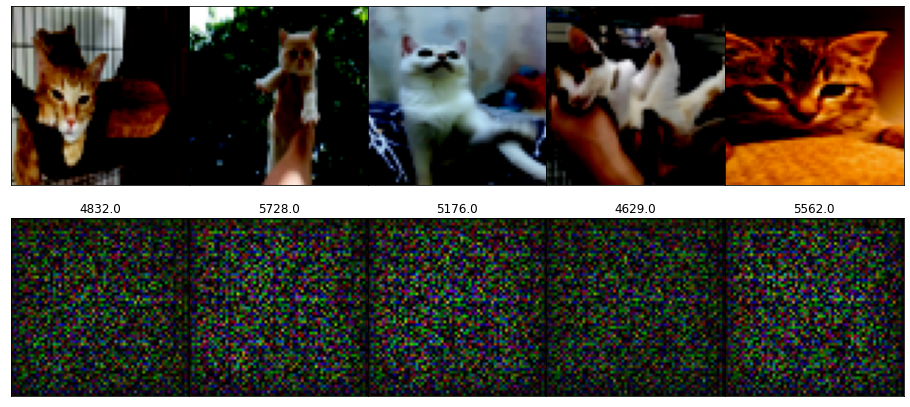

In [98]:
def inference(z, sample, G, D):
    G.to(device)
    D.to(device)
    G.eval()
    D.eval()
    z = z.to(device)

    with torch.no_grad():
        fake_img = G(z)

    _, loss = criterion(sample, fake_img, D)
    loss = loss.cpu().detach().numpy()
    loss = np.round(loss, 0)
    fig, axes = plt.subplots(2, 5, figsize=(16, 5))
    ax = axes.ravel()
    for i in range(sample.size()[0]):
        ax[i].imshow(sample[i].permute(1, 2, 0))
        ax[i+5].imshow(fake_img[i].permute(1, 2, 0))
        ax[i+5].set_title(loss[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i+5].set_xticks([])
        ax[i+5].set_yticks([])
    plt.subplots_adjust(top=1.3, wspace=0, hspace=0)
    plt.show()
inference(z, sample, G, D)